# Importing the FORWAST database

[FORWAST](http://forwast.brgm.fr/Overview.asp) is a physical MRIO table for Europe.

In [1]:
from brightway2 import *

In [2]:
projects.set_current("forwast")
bw2setup()

Biosphere database already present!!! No setup is needed


We start with an export of the database from SimaPro, provided by the FORWAST team.

In [3]:
ei = SingleOutputEcospold1Importer("/Users/cmutel/Downloads/FORWAST-ecospold1", "forwast")
ei.apply_strategies()
ei.statistics()

Extracting ecospold1 files:
0%                          100%
[##############################] | ETA[sec]: 0.000 | Item ID: /Users/cmutel/D
Total time elapsed: 3.399 sec


Title: Extracting ecospold1 files:
  Started: 10/22/2015 01:12:28
  Finished: 10/22/2015 01:12:31
  Total time elapsed: 3.399 sec
  CPU %: 87.000000
  Memory %: 1.817799
Extracted 277 datasets in 3.40 seconds
Applying strategy: normalize_units
Applying strategy: assign_only_product_as_production
Applying strategy: clean_integer_codes
Applying strategy: drop_unspecified_subcategories
Applying strategy: normalize_biosphere_categories
Applying strategy: normalize_biosphere_names
Applying strategy: strip_biosphere_exc_locations
Applying strategy: set_code_by_activity_hash
Applying strategy: link_iterable_by_fields
Applying strategy: link_technosphere_by_activity_hash
Applied 10 strategies in 2.59 seconds
277 datasets
82546 exchanges
80884 unlinked exchanges
  Type biosphere: 16 unique unlinked exchanges
  Type production: 277 unique unlinked exchanges
  Type technosphere: 275 unique unlinked exchanges


(277, 82546, 80884)

# Major linking problems

The first problem is that each process has a category, but none of the exchanges do. The IO library can't link them using its default algorithm, which includes categories when matching. Luckily, we can easily define a new strategy that doesn't include categories.

In [4]:
from bw2io.strategies import link_iterable_by_fields
import functools

without_subcategories = functools.partial(link_iterable_by_fields, fields=['name', 'unit'], internal=True)
ei.apply_strategy(without_subcategories)

ei.statistics()

Applying strategy: link_iterable_by_fields
277 datasets
82546 exchanges
4432 unlinked exchanges
  Type biosphere: 16 unique unlinked exchanges


(277, 82546, 4432)

# Biosphere flow conflicts

The next problem is that there are several biosphere flows that have non-matching names or categories, when compared to our base biosphere flow list. There isn't an automatic way to fix this; rather, I used code like:

    db = Database("biosphere3")
    db.search("natural gas")
    
to find out what flows were in our reference list, and what fields needed to change so that matching could occur. We use the migrations functionality to fix only the fields we need to change.

In [5]:
migration_data = {
    'fields': ['name', 'categories', 'type', 'unit'],
    'data': [
        (
            ('Aluminium', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'categories': ('natural resource', 'in ground'),
                'name': 'Aluminium, in ground',
            }
        ),
        (
            ('Carbon dioxide, in air', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'categories': ('natural resource', 'in air'),
            }
        ),
        (
            ('Carbon monoxide', ('air',), 'biosphere', 'kilogram'),
            {
                'name': 'Carbon monoxide, fossil',
            }
        ),
        (
            ('Coal, hard', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'categories': ('natural resource', 'in ground'),
                'name': 'Coal, hard, unspecified, in ground',
            }
        ),
        (
            ('Gas, natural, 46.8 MJ per kg', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'categories': ('natural resource', 'in ground'),
                'name': 'Gas, natural, in ground',
                'unit': 'cubic meter',
                'multiplier': 1 / 0.8  # Approximation, density varies from 0.7/0.9 km/m3
            }
        ),
        (
            ('Sand and clay', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'categories': ('natural resource', 'in ground'),
                'name': 'Sand, unspecified, in ground',
            }
        ),
        (
            ('Methane', ('air',), 'biosphere', 'kilogram'),
            {
                'name': 'Methane, fossil',
            }
        ),
        (
            ('Nitrogen dioxide', ('air',), 'biosphere', 'kilogram'),
            {
                'name': 'Nitrogen oxides',
            }
        ),
        (
            ('Oil, crude', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'name': 'Oil, crude, in ground',
                'categories': ('natural resource', 'in ground'),
            }
        ),
        (
            ('Zinc', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'name': 'Zinc, Zn 0.63%, in mixed ore, in ground',
                'categories': ('natural resource', 'in ground'),
            }
        ),
        (
            ('Lead', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'name': 'Lead, Pb 0.014%, in mixed ore, in ground',
                'categories': ('natural resource', 'in ground'),
            }
        ),
        (
            ('Iron', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'name': "Iron, 46% in ore, 25% in crude ore, in ground",
                'categories': ('natural resource', 'in ground'),
            }
        ),
        (
            ('Copper', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'name': "Copper, 1.13% in sulfide, Cu 0.76% and Ni 0.76% in crude ore, in ground",
                'categories': ('natural resource', 'in ground'),
            }
        ),
        (
            ('Nickel', ('natural resource',), 'biosphere', 'kilogram'),
            {
                'name': 'Nickel, 1.98% in silicates, 1.04% in crude ore, in ground',
                'categories': ('natural resource', 'in ground'),
            }
        )
    ]
}

migration = Migration("simapro-forwast")
migration.write(
    migration_data, 
    description="Migration for biosphere flows from FORWAST database, as imported into SimaPro"
)

We then apply our migration.

In [6]:
ei.migrate("simapro-forwast")
ei.apply_strategy(ei.strategies[-2])

ei.statistics()

Applying strategy: migrate_datasets
Applied 1 strategies in 0.00 seconds
Applying strategy: migrate_exchanges
Applied 1 strategies in 0.72 seconds
Applying strategy: link_iterable_by_fields
277 datasets
82546 exchanges
554 unlinked exchanges
  Type biosphere: 2 unique unlinked exchanges


(277, 82546, 554)

This is very good. Let's look at the remaining two flows:

In [7]:
for x in ei.unlinked:
    print(x)

{'unit': 'kilogram', 'categories': ['natural resource'], 'loc': 0.0, 'type': 'biosphere', 'name': 'Other minerals, extracted for use', 'amount': 0.0, 'uncertainty type': 0}
{'unit': 'kilogram', 'categories': ['natural resource'], 'loc': 0.0, 'type': 'biosphere', 'name': 'Other minerals, related unused extraction', 'amount': 0.0, 'uncertainty type': 0}


We don't actually care about these `other minerals`, so just drop them.

In [8]:
ei.drop_unlinked()

Our IO library doesn't like dropping unlinked exchanges, but we are comfortable with this, so we proceed anyway.

In [9]:
ei.drop_unlinked(i_am_reckless=True)

Applying strategy: drop_unlinked
Applied 1 strategies in 0.02 seconds


One last manipulation before writing to disk: Let's delete all exchanges with zero amounts, as this is just noise.

In [10]:
for ds in ei.data:
    ds['exchanges'] = [exc for exc in ds['exchanges'] if (exc['amount'] or exc['uncertainty type'] != 0)]
    
ei.statistics()

277 datasets
39194 exchanges
0 unlinked exchanges
  


(277, 39194, 0)

Removing exchanges with zero amounts and no uncertainty reduced the database size by over half. As zero is the default value for any value in our matrix, unless specified otherwise, we haven't lost any information. To prevent others from having to do the same manipulation, we write the database, and then export a Brightway2 package for easy installation in the future.

In [11]:
ei.write_database()

Writing activities to SQLite3 database:
0%                          100%
[##############################] | ETA[sec]: 0.000 
Total time elapsed: 4.485 sec


Title: Writing activities to SQLite3 database:
  Started: 10/22/2015 01:12:38
  Finished: 10/22/2015 01:12:42
  Total time elapsed: 4.485 sec
  CPU %: 82.800000
  Memory %: 1.911306
Created database: forwast


Brightway2 SQLiteBackend: forwast

In [12]:
BW2Package.export_obj(Database("forwast"))

'/Users/cmutel/Library/Application Support/Brightway3/forwast.32da010eda2c41550eea7e9738352ed8/export/forwast32da010eda2c41550eea7e9738352ed8.ace1d2f119ec9f69e6206fb5758b4a8d.bw2package'

Finally, let's visualize the database technosphere matrix:

In [13]:
%matplotlib inline

In [14]:
from bw2analyzer.matrix_grapher import SparseMatrixGrapher

In [15]:
lca = LCA({Database('forwast').random(): 1})
lca.lci()

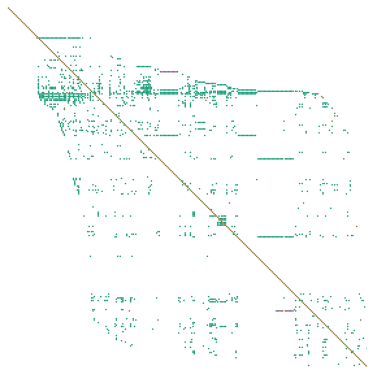

In [16]:
# Skip a bunch of very large negative numbers... ?
lca.technosphere_matrix[lca.technosphere_matrix < 0] = 0
SparseMatrixGrapher(lca.technosphere_matrix).magnitude_graph(width=5, height=5)